# CSE 5524 HW10 Utkarsh Pratap Singh Jadon

## Question 1

### Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
import cv2 as cv
import numpy as np
import math
from PIL import Image
import glob
import os
import skimage
from os import listdir
from os.path import join, isfile
from skimage import morphology
from skimage import measure,color
from skimage import io, data 
from numpy.linalg import eig
from scipy import ndimage, misc
from scipy.ndimage import median_filter
import matplotlib.patches as patches

### Read and display left and right images

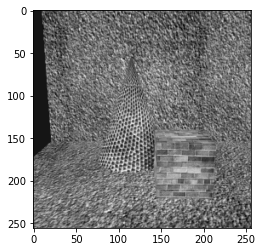

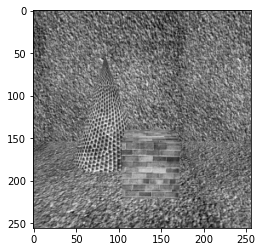

In [2]:
leftImage = skimage.io.imread('left.png')
rightImage = skimage.io.imread('right.png')

plt.subplot(1,1,1)
plt.imshow(leftImage,cmap ='gray')
plt.show()

plt.subplot(1,1,1)
plt.imshow(rightImage,cmap='gray')
plt.show()

### Write a function stereoMatch to compute dispartiy map

In [73]:
def stereoMatch(left_img, right_img, kernel=11, maxOffset=50):
    
    a, b = left_img.shape 
    disparityMap = np.zeros((a, b), np.uint8)
    kernelHalf = kernel // 2 
      
    for i in range(kernelHalf, a - kernelHalf):      
        for j in range(kernelHalf, b - kernelHalf):
            bestOffset = 0
            prev_ncc = float("-inf")
            
            for offset in range(maxOffset):   
                nccValue = 0
                
                leftWindow = left_img[i - kernelHalf : i + kernelHalf, j - kernelHalf : j + kernelHalf]
                rightWindow = right_img[i - kernelHalf : i + kernelHalf, j - kernelHalf : j + kernelHalf]
                
                leftWindowMean = leftWindow.mean()
                leftWindowSTD = np.std(leftWindow, ddof = 1)
                rightWindowMean = rightWindow.mean()
                rightWindowSTD = np.std(rightWindow, ddof = 1)
                
                for k in range(-kernelHalf, kernelHalf):
                    for l in range(-kernelHalf, kernelHalf):
                        ncc_temp = (int(left_img[i+k, j+l]) - leftWindowMean) * (int(right_img[i+k, (j+l) - offset]) - rightWindowMean)
                        if leftWindowSTD == 0 or rightWindowSTD == 0:
                            ncc_temp = 0
                        else:
                            ncc_temp /= leftWindowSTD * rightWindowSTD
                        nccValue += ncc_temp             
                if nccValue > prev_ncc:
                    prev_ncc = nccValue
                    bestOffset = offset
            disparityMap[i][j] = j - (j - bestOffset)
    
    return disparityMap


### Call above function to generate map D

In [74]:
# This section takes about 7 minutes to run (M2 Air)

D = stereoMatch(leftImage, rightImage, 11, 50)

### Clip disparity map D values at 50

In [75]:
Dclipped = np.clip(D, 0, 50)

### Display clipped disparity map D using skimage.io.imshow

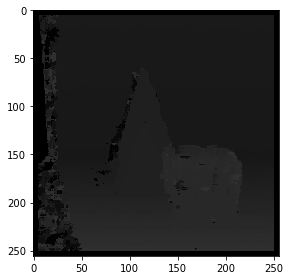

In [76]:
skimage.io.imshow(Dclipped,cmap='gray')

### Display clipped disparity map D using plt.imshow

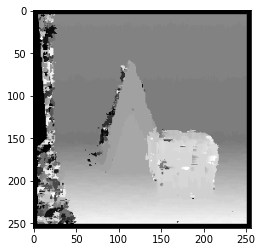

In [77]:
plt.imshow(Dclipped,cmap ='gray')

### Discussion

I implemented basic stereo matching algorithm, wherein for each patch in left image, I performed template matching using NCC in right image, by searching 50 pixels leftwards from the starting point along each row, using a window of size 11 x 11, and generated disparity map D. Later, I clipped the pixel values of D at 50, to get clipped disparity map Dclipped and displayed it using skimage.io.imshow and plt.imshow.

## Question 2

In [78]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

### Load training data and split into classes

In [153]:
trainingData = np.loadtxt('train.txt')

xtr = trainingData[:,0]
ytr = trainingData[:,1]
labels = trainingData[:,2]

#Split training data into two classes

class1 = []
class2 = []

for i in range(1000):
    if(labels[i] == 1):
        class1.append([xtr[i], ytr[i]])
    else:
        class2.append([xtr[i], ytr[i]])

class1 = np.array(class1)
class2 = np.array(class2)

#print(class1.shape)

### Load test data

In [85]:
testData = np.loadtxt('test.txt')
xts = testData[:,0]
yts = testData[:,1]
trueLabels = testData[:,2]

### Compute distances between test and labeled training samples

In [105]:
DistAll=[]
dist = []

for i in range(1000):
    X = xts[i] * np.ones(1000)
    Y = yts[i] * np.ones(1000)
    dx = X - xtr
    dy = Y - ytr
    dist = []
    
    for j  in range(1000):
        dist.append(math.sqrt(dx[j]**2 + dy[j]**2))
    dist = np.array(dist)
    DistAll.append(dist)

### Write function to compute KNN

In [126]:
def computeKNN(k,dist):
    a = np.argsort(dist)
    knn = labels[a[0:k]]
    vals, counts = np.unique(knn, return_counts = True)
    mode_value = np.argwhere(counts == np.max(counts))
    res = vals[mode_value].flatten().tolist()
    return res[0]

### KNN for k = 1

In [145]:
KNNClasses1=[]
k = 1
for i in range(1000):
    knn_class = computeKNN(k,DistAll[i])
    KNNClasses1.append(knn_class)

Number of mislabeled points = 28
Accuracy = 97.2


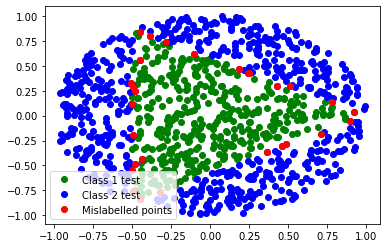

In [146]:
#Split test data into different classes
Class1 = []
Class2 = []
for i in range(1000):
    if(KNNClasses1[i]==1):
        Class1.append([xts[i],yts[i]])
    else:
        Class2.append([xts[i],yts[i]])
Class1 = np.array(Class1)
Class2 = np.array(Class2)

#Calculate test data points that are misclassified
mislabeled=[]
for i in range(1000):
    if(KNNClasses1[i]!=trueLabels[i]):
        mislabeled.append([xts[i],yts[i]])
mislabeled=np.array(mislabeled)
print("Number of mislabeled points = {}".format(mislabeled.shape[0]))
print("Accuracy = {}".format(((1000 - mislabeled.shape[0]) / 1000) * 100))

#Plot the test data predicted labels and true label
plt.plot(Class1[:,0],Class1[:,1],'o',color='green')
plt.plot(Class2[:,0],Class2[:,1],'o',color='blue')
plt.plot(mislabeled[:,0],mislabeled[:,1],'ko',color='red')

plt.legend(['Class 1 test','Class 2 test','Mislabelled points'],loc='lower left')

### KNN for k = 5

In [147]:
KNNClasses1=[]
k = 5
for i in range(1000):
    knn_class = computeKNN(k,DistAll[i])
    KNNClasses1.append(knn_class)

Number of mislabeled points = 30
Accuracy = 97.0


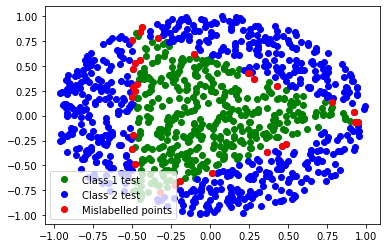

In [148]:
#Split test data into different classes
Class1 = []
Class2 = []
for i in range(1000):
    if(KNNClasses1[i]==1):
        Class1.append([xts[i],yts[i]])
    else:
        Class2.append([xts[i],yts[i]])
Class1 = np.array(Class1)
Class2 = np.array(Class2)

#Calculate test data points that are misclassified
mislabeled=[]
for i in range(1000):
    if(KNNClasses1[i]!=trueLabels[i]):
        mislabeled.append([xts[i],yts[i]])
mislabeled=np.array(mislabeled)
print("Number of mislabeled points = {}".format(mislabeled.shape[0]))
print("Accuracy = {}".format(((1000 - mislabeled.shape[0]) / 1000) * 100))

#Plot the test data predicted labels and true label
plt.plot(Class1[:,0],Class1[:,1],'o',color='green')
plt.plot(Class2[:,0],Class2[:,1],'o',color='blue')
plt.plot(mislabeled[:,0],mislabeled[:,1],'ko',color='red')

plt.legend(['Class 1 test','Class 2 test','Mislabelled points'],loc='lower left')

### KNN for k = 11

In [149]:
KNNClasses1=[]
k = 11
for i in range(1000):
    knn_class = computeKNN(k,DistAll[i])
    KNNClasses1.append(knn_class)

Number of mislabeled points = 33
Accuracy = 96.7


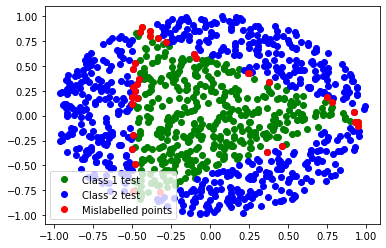

In [150]:
#Split test data into different classes
Class1 = []
Class2 = []
for i in range(1000):
    if(KNNClasses1[i]==1):
        Class1.append([xts[i],yts[i]])
    else:
        Class2.append([xts[i],yts[i]])
Class1 = np.array(Class1)
Class2 = np.array(Class2)

#Calculate test data points that are misclassified
mislabeled=[]
for i in range(1000):
    if(KNNClasses1[i]!=trueLabels[i]):
        mislabeled.append([xts[i],yts[i]])
mislabeled=np.array(mislabeled)
print("Number of mislabeled points = {}".format(mislabeled.shape[0]))
print("Accuracy = {}".format(((1000 - mislabeled.shape[0]) / 1000) * 100))

#Plot the test data predicted labels and true label
plt.plot(Class1[:,0],Class1[:,1],'o',color='green')
plt.plot(Class2[:,0],Class2[:,1],'o',color='blue')
plt.plot(mislabeled[:,0],mislabeled[:,1],'ko',color='red')

plt.legend(['Class 1 test','Class 2 test','Mislabelled points'],loc='lower left')

### KNN for k = 15

In [151]:
KNNClasses1=[]
k = 15
for i in range(1000):
    knn_class = computeKNN(k,DistAll[i])
    KNNClasses1.append(knn_class)

Number of mislabeled points = 29
Accuracy = 97.1


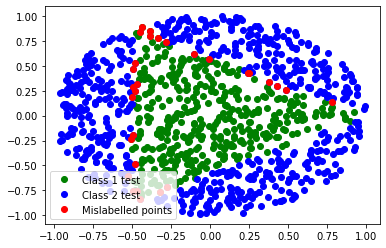

In [152]:
#Split test data into different classes
Class1 = []
Class2 = []
for i in range(1000):
    if(KNNClasses1[i]==1):
        Class1.append([xts[i],yts[i]])
    else:
        Class2.append([xts[i],yts[i]])
Class1 = np.array(Class1)
Class2 = np.array(Class2)

#Calculate test data points that are misclassified
mislabeled=[]
for i in range(1000):
    if(KNNClasses1[i]!=trueLabels[i]):
        mislabeled.append([xts[i],yts[i]])
mislabeled=np.array(mislabeled)
print("Number of mislabeled points = {}".format(mislabeled.shape[0]))
print("Accuracy = {}".format(((1000 - mislabeled.shape[0]) / 1000) * 100))

#Plot the test data predicted labels and true label
plt.plot(Class1[:,0],Class1[:,1],'o',color='green')
plt.plot(Class2[:,0],Class2[:,1],'o',color='blue')
plt.plot(mislabeled[:,0],mislabeled[:,1],'ko',color='red')

plt.legend(['Class 1 test','Class 2 test','Mislabelled points'],loc='lower left')

### Discussion

We observe that there is very slight variation in the performance of KNN for different values of K. We get maximum accuracy for K=1 (97.2%) followed by K=15 (97.1%), K=5 (97.0%), and K=11 (96.7%). For smaller values of K, model is more complex, variance is high, classifier is sensitive to noise, and may lead to overfitting. For larger values of K, classifier boundary is smoother, model is less complex, variance is low, and it may lead to underfitting.